In [1]:
from VisionEngine.datasets import guppies
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory
import sys
import os
from PIL import Image
from itertools import product
from dotenv import load_dotenv
from pathlib import Path

import numpy as np
import scipy

import numba

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.metrics import pairwise_distances
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

from openTSNE import TSNE
from openTSNE.sklearn import TSNE as sklTSNE
from openTSNE.callbacks import ErrorLogger

import sys
import math

import tensorflow as tf
from tensorflow.keras.layers import Flatten

In [2]:
cd ..

/home/etheredge/Workspace/VisionEngine


In [3]:
checkpoint_path = '/home/etheredge/Workspace/VisionEngine/checkpoints/butterfly_periodic/2020-205-14/butterfly_periodic.hdf5'

In [4]:
config_file = 'VisionEngine/configs/butterfly_periodic_config.json'
config = process_config(config_file)

In [5]:
config.data_loader.use_generated = False
config.data_loader.use_real = True

In [6]:
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [7]:
data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)

importing VisionEngine.data_loaders.vae_data_loader
getattr DataLoader


In [8]:
model = factory.create(
            "VisionEngine.models."+config.model.name
            )(config)

importing VisionEngine.models.vae_model
getattr VAEModel
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 984064), (No 9918848     input_2[0][0]                    
__________________________________________________________________________________________________
dense_siren (DenseSiren)        (None, 10)           9840650     encoder[1][0]                    
__________________________________________________________________________________________________
dense_siren_2 (DenseSiren)      (None, 10)        

In [9]:
model.load(checkpoint_path)

Loading model checkpoint /home/etheredge/Workspace/VisionEngine/checkpoints/butterfly_periodic/2020-205-14/butterfly_periodic.hdf5 ...

Model loaded


In [10]:
class LikeLihoodLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LikeLihoodLayer, self).__init__(**kwargs)
        self.model_input_shape = [256, 256, 3]

    def build(self, input_shape):
        super(LikeLihoodLayer, self).build(input_shape)

    def call(self, layer_inputs, **kwargs):
        inputs, outputs = layer_inputs
        mse = - tf.losses.mean_squared_error(inputs, outputs)
        out = 1./(tf.sqrt(2.*math.pi))*tf.exp(-.5*(mse)**2.)
        return out

        return [y_true, y_pred]
    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def get_config(self):
        config = {}
        base_config = \
            super(LikeLihoodLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def sample_likelihood(x):
    inputs = Flatten()(model.model.input)
    outputs = Flatten()(model.model.output)
    out = LikeLihoodLayer()([inputs, outputs])
    lh_model = Model(model.model.input, out)
    return lh_model.predict(x)

def embed_images(x):
    outputs = [
        model.model.get_layer('normal_variational').output,
        model.model.get_layer('normal_variational_1').output,
        model.model.get_layer('normal_variational_2').output,
        model.model.get_layer('normal_variational_3').output
    ]
    encoder = Model(model.model.inputs, outputs)
    return encoder.predict(x)

def reconstruct_images(x):
    return model.model.predict(x)

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca();
    try:
        image = plt.imread(image);
    except TypeError:
        # Likely already an array...
        pass
    x, y = np.atleast_1d(x, y);
    artists = [];
    for i, (x0, y0) in enumerate(zip(x, y)):
        im = OffsetImage(image[i], zoom=zoom);
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False);
        artists.append(ax.add_artist(ab));
    ax.update_datalim(np.column_stack([x, y]));
    ax.autoscale();
    ax.grid(False);
    return artists

def plot_im(img):
    if config.model.last_activation == 'tanh':
        img * 0.5 + 0.5
        return img
    else:
        return img

In [11]:
z = embed_images(data_loader.get_test_data())
lh = sample_likelihood(data_loader.get_test_data())

In [12]:
labels = []
images = []
for image, label in data_loader.get_test_data().take(100):
    labels.append(label.numpy())
    images.extend(image.numpy())
images = np.stack(images)
labels = np.array(labels)

In [13]:
images.shape

(1600, 256, 256, 3)

In [14]:
x_hat = reconstruct_images(data_loader.get_test_data().take(100))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


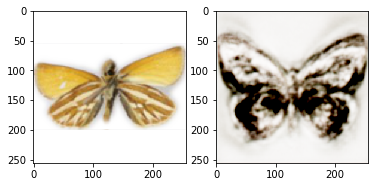

In [20]:
ID = 10
plt.subplot(121)
plt.imshow(plot_im(images[ID]))
plt.subplot(122)
plt.imshow(plot_im(x_hat[ID]))

In [16]:
np.concatenate([z[0],z[1],z[2],z[3]], axis=1).shape

(9531, 40)

In [17]:
vision_engine_embedding = TSNE(callbacks=ErrorLogger(), n_jobs=8, exaggeration=4, learning_rate=len(z)/12).fit(np.concatenate([z[0],z[1],z[2],z[3]], axis=1))
h1 = TSNE(callbacks=ErrorLogger(), exaggeration=4, learning_rate=len(z)/12, n_jobs=8).fit(z[0])
h2 = TSNE(callbacks=ErrorLogger(), exaggeration=4, learning_rate=len(z)/12, n_jobs=8).fit(z[1])
h3 = TSNE(callbacks=ErrorLogger(), exaggeration=4, learning_rate=len(z)/12, n_jobs=8).fit(z[2])
h4 = TSNE(callbacks=ErrorLogger(), exaggeration=4, learning_rate=len(z)/12, n_jobs=8).fit(z[3])

Iteration   50, KL divergence  5.3059, 50 iterations in 3.5750 sec
Iteration  100, KL divergence  5.3060, 50 iterations in 3.5485 sec
Iteration  150, KL divergence  5.3060, 50 iterations in 3.4894 sec
Iteration  200, KL divergence  5.3061, 50 iterations in 3.4554 sec
Iteration  250, KL divergence  5.3061, 50 iterations in 3.5514 sec
Iteration   50, KL divergence  5.3061, 50 iterations in 3.4748 sec
Iteration  100, KL divergence  5.3061, 50 iterations in 3.5757 sec
Iteration  150, KL divergence  5.3061, 50 iterations in 3.3783 sec
Iteration  200, KL divergence  5.3061, 50 iterations in 3.5154 sec
Iteration  250, KL divergence  5.3061, 50 iterations in 3.4306 sec
Iteration  300, KL divergence  5.3061, 50 iterations in 3.3691 sec
Iteration  350, KL divergence  5.3061, 50 iterations in 3.5893 sec
Iteration  400, KL divergence  5.3061, 50 iterations in 3.4857 sec
Iteration  450, KL divergence  5.3061, 50 iterations in 3.3058 sec
Iteration  500, KL divergence  5.3061, 50 iterations in 3.3591

In [18]:
labels = []
images = []
for image, label in data_loader.get_plot_data():
    labels.append(label.numpy().decode('utf8'))
    images.append(image.numpy().astype('uint8'))
images = np.stack(images)
labels = np.array(labels)

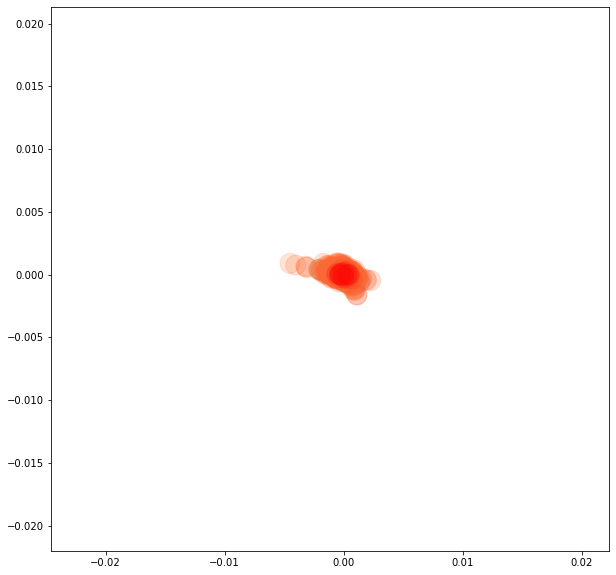

In [19]:
plt.figure(figsize=(10,10))
classnames, indices = np.unique( labels, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

embedding = vision_engine_embedding

plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)


In [15]:
plt.figure(figsize=(80,80))
# plt.scatter(vision_engine_embedding[:,0],vision_engine_embedding[:,1],c=lh, s=10000)
# plt.colorbar()
embedding = vision_engine_embedding
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.60);
fig = plt.gcf()
fig.savefig('what.png')

In [23]:
ranked_lh_args = np.argsort(lh)[::-1]

In [24]:
lh[ranked_lh_args[:10]]

array([0.39894214, 0.39894214, 0.39894208, 0.39894208, 0.39894202,
       0.39894202, 0.398942  , 0.398942  , 0.398942  , 0.398942  ],
      dtype=float32)

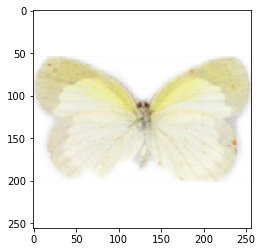

In [32]:
plt.imshow(images[ranked_lh_args[6]])

In [13]:
pwd

'/home/etheredge/Workspace/VisionEngine'

In [29]:
image_output_folder = 'report_wppvae_gens/figures/images/{}'.format(checkpoint_path.split('/')[7])
plot_output_folder = 'report_wppvae_gens/figures/panels{}'.format(checkpoint_path.split('/')[7])
n_latents = 4 
latent_size = 10
Path(image_output_folder).mkdir(parents=True, exist_ok=True)
Path(plot_output_folder).mkdir(parents=True, exist_ok=True)

In [30]:
pwd

'/home/etheredge/Workspace/VisionEngine'

In [31]:
np.max(z[1])

14.093723

In [32]:
def make_rand_samples(model, n_samples=9, num_steps=300, mu=0., sigma=1.):
    output_folder = os.path.join(image_output_folder, 'explore_latents/random_normal/frames')
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    sample =  [
        np.random.multivariate_normal([mu] * latent_size,np.diag([sigma] * latent_size), n_samples)
        ] * n_latents

    for z in range(n_latents):
        for t in range(num_steps):
            sample[z] = np.random.multivariate_normal(
                [mu] * latent_size, np.diag([sigma] * latent_size), n_samples)
            generated = model.get_layer('decoder').predict(sample, batch_size=10)
            generated = generated.reshape((n_samples, 256, 256,3))
            image_container = Image.new('RGB', (256*3,256*3))
            locs = list(product(range(int(np.sqrt(n_samples))),range(int(np.sqrt(n_samples)))))
            for i in range(n_samples):
                img = generated[i]
                j, k = locs[i]
                img = 255 * np.array(img)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (k*256, j*256))
            image_container.save(os.path.join(output_folder,'z{}_{:03d}.png'.format(z,t)))


def make_traversal_from_zeros(model, n_samples=1, num_steps=11):
    output_folder = os.path.join(image_output_folder, 'explore_latents/traversal')
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    multipliers = np.linspace(-3,3,num=num_steps)

    for z_i in range(4):
        image_container = Image.new('RGB', (256*num_steps,256*latent_size))
        for z_i_j in range(latent_size):
            for s in range(num_steps):
                sample = [np.array([[0] * latent_size]),
                        np.array([[0] * latent_size]),
                        np.array([[0] * latent_size]),
                        np.array([[0] * latent_size])]
                
                sample[z_i][0][z_i_j] = multipliers[s]
                generated = model.get_layer('decoder').predict(sample, batch_size=1)
                generated = generated.reshape((256, 256,3))
                img = 255 * np.array(generated)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (s*256, z_i_j*256))
        image_container.save(os.path.join(output_folder,'z{}.png'.format(z_i)))


def make_traversal_from_sample(model, z, n_samples=1, num_steps=11, sample_id=0):
    output_folder = os.path.join(image_output_folder, 'explore_latents/traversal')
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    multipliers = np.linspace(-3,3,num=num_steps)
    encoded_sample = [z_i[sample_id] for z_i in z]

    for z_i in range(4):
        image_container = Image.new('RGB', (256*num_steps,256*latent_size))
        for z_i_j in range(latent_size):
            for s in range(num_steps):
                sample = [np.array([encoded_sample[0]]),
                      np.array([encoded_sample[1]]),
                      np.array([encoded_sample[2]]),
                      np.array([encoded_sample[3]])]
                
                sample[z_i][0][z_i_j] = multipliers[s]
                generated = model.get_layer('decoder').predict(sample, batch_size=1)
                generated = generated.reshape((256, 256, 3))
                img = 255 * np.array(generated)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (s*256, z_i_j*256))
        image_container.save(os.path.join(output_folder,'{}sample{}.png'.format(sample_id, z_i)))


In [33]:
make_rand_samples(model.model)

In [34]:
make_traversal_from_sample(model.model, z, sample_id=1350)

In [22]:
make_traversal_from_zeros(model.model)

In [ ]:
vision_engine_embedding1 = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[0])/12, exaggeration=4).fit(np.array(z[0]))
vision_engine_embedding2 = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[1])/12, exaggeration=4).fit(np.array(z[1]))
vision_engine_embedding3 = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[2])/12, exaggeration=4).fit(np.array(z[2]))
vision_engine_embedding4 = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[3])/12, exaggeration=4).fit(np.array(z[3]))

In [ ]:
plt.figure(figsize=(80,40))

classnames, indices = np.unique( labels, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.subplot(241)
embedding = vision_engine_embedding1
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);


plt.subplot(242)
embedding = vision_engine_embedding2
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);

plt.subplot(243)
embedding = vision_engine_embedding3
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);

plt.subplot(244)
embedding = vision_engine_embedding4
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);

plt.subplot(245)
embedding = vision_engine_embedding1
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(246)
embedding = vision_engine_embedding2
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(247)
embedding = vision_engine_embedding3
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(248)
embedding = vision_engine_embedding4
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

# fig = plt.gcf()
# fig.savefig(os.path.join(
#     plot_output_folder,
#     'Zs_{}_real{}_gen{}.pdf'.format(
#         checkpoint_path.split('/')[7],
#         config.data_loader.use_real,
#         config.data_loader.use_generated
#     )
# )
#            )
# fig.savefig(os.path.join(
#     plot_output_folder,
#     'Zs_{}_real{}_gen{}.png'.format(
#         checkpoint_path.split('/')[7],
#         config.data_loader.use_real,
#         config.data_loader.use_generated
#     )
# )
#            )
# plt.clf()

In [ ]:
def make_perceptual_loss_model(input_shape, layers=[13]):
    loss_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)
    loss_model.trainable = False
    for layer in loss_model.layers:
        layer.trainable = False
    loss_layers = [ loss_model.layers[i].output
                for i in layers
                ]
    return Model(loss_model.inputs,loss_layers)

# @numba.jit(nopython=True, parallel=True)
# def calculate_perceptual_distances(X):
#     dists = np.zeros((989,989))
#     for layer in X:
#         layer.shape
#         for i in range(layer.shape[0]):
#             for j in range(layer.shape[0]):
#                 shape = (layer[i].shape[0]*layer[i].shape[1]*layer[i].shape[2])
#                 sqr = np.square(layer[i] - layer[j])
#                 sm = np.sum(sqr)
#                 val = sm / shape
#                 dists[i,j] =+ val
#     return dists


@numba.jit(nopython=True, parallel=True)
def calculate_perceptual_distances(X):
    norm_dists = np.zeros((len(X[0]),len(X)))
    for i in range(len(X)):
        for j in range(len(X[0])):
            norm_dists[j, i] = np.linalg.norm(X[i][j].flatten())
    return norm_dists

In [ ]:
perceptual_model = make_perceptual_loss_model((256,256,3))

In [ ]:
perception = perceptual_model.predict(data_loader.get_test_data()[0], batch_size=5)
perceptual_dists = calculate_perceptual_distances(perception)

In [ ]:
raw_image_embedding = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[0])/12, exaggeration=4).fit(images.flatten())
perceptual_embedding = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[0])/12, exaggeration=4).fit(perceptual_dists)
vision_engine_embedding = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[3])/12, exaggeration=4).fit(np.concatenate([z[0], z[1], z[2], z[3]]))

In [ ]:
classnames, indices = np.unique( labels, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(40,40))

plt.subplot(231)
embedding = raw_image_embedding
imscatter(embedding[:, 0], embedding[:, 1], data_loader.get_test_data()[0], zoom=0.40);
plt.subplot(234)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(232)
embedding = perceptual_embedding
imscatter(embedding[:, 0], embedding[:, 1], data_loader.get_test_data()[0], zoom=0.40);
plt.subplot(235)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(233)
embedding = vision_engine_embedding
classnames, indices = np.unique(y_train, return_inverse=True)
plt.subplot(236)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

fig = plt.gcf()
fig.savefig(os.path.join(
    plot_output_folder,
    'compare_methods_{}.pdf'.format(
        checkpoint_path.split('/')[7]
    )
)
fig.savefig(os.path.join(
    plot_output_folder,
    'compare_methods_{}.png'.format(
        checkpoint_path.split('/')[7]
    )
)
plt.clf()